# MLops Project (Praxis_Hackathon_2023):

### Importing Libraries:

In [79]:
import warnings
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from IPython.display import display
import statsmodels.api as sm
from xgboost import XGBRFRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

### Given Train Dataset:

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


### Size of dataset:

In [3]:
train_df.shape

(209673, 8)

### Total Number of Columns:

In [4]:
total_train_cols = train_df.columns.tolist()
print(total_train_cols)

['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare', 'tip', 'miscellaneous_fees', 'total_fare', 'surge_applied']


### Breaking total features into Input & Target Feature:

In [5]:
target_feature = 'total_fare'
input_features = total_train_cols
input_features.remove(target_feature)
print('target feature = ', target_feature)
print('\ninput features = ', input_features)

target feature =  total_fare

input features =  ['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare', 'tip', 'miscellaneous_fees', 'surge_applied']


### What are the different datatypes present inside given dataframe?

In [6]:
train_df.dtypes.value_counts()

float64    6
int64      2
dtype: int64

### Dataset Info:

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


## Preprocessing on Training Data:
### Converting dataype of surge_applied to category:

In [8]:
train_df['surge_applied'] = train_df['surge_applied'].astype('category')
train_df.dtypes

trip_duration          float64
distance_traveled      float64
num_of_passengers      float64
fare                   float64
tip                      int64
miscellaneous_fees     float64
total_fare             float64
surge_applied         category
dtype: object

### Checking Null Values:

In [9]:
train_df.isna().sum(axis=0)

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

### Checking Duplicate Values:

In [10]:
train_df.duplicated(keep='first').sum()

4325

### Which one are the duplicated rows:

In [11]:
train_df[train_df.duplicated(keep='first')]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
2801,630.0,2.54,1.0,63.75,0,6.00,69.75,0
3901,678.0,3.33,1.0,71.25,15,6.45,92.70,0
5771,365.0,1.45,1.0,45.00,0,6.00,51.00,0
6042,441.0,2.11,1.0,52.50,12,5.70,70.20,0
6425,395.0,1.61,1.0,48.75,0,6.00,54.75,0
...,...,...,...,...,...,...,...,...
209486,505.0,2.33,1.0,56.25,0,6.00,62.25,0
209515,478.0,1.67,1.0,52.50,12,5.70,70.20,0
209556,1011.0,2.88,1.0,86.25,0,6.00,92.25,0
209607,687.0,3.17,1.0,71.25,0,6.00,77.25,0


### Dropping Duplicate Rows:

In [12]:
print('train dataset has {} rows and {} columns' .format(train_df.shape[0], train_df.shape[1]))
train_df1 = train_df.copy()
train_df1.drop_duplicates(inplace=True)
print('After dropping duplicates, train dataset has {} rows and {} columns' \
      .format(train_df1.shape[0], train_df1.shape[1]))

train dataset has 209673 rows and 8 columns
After dropping duplicates, train dataset has 205348 rows and 8 columns


### Description of Numerical Features:

In [13]:
train_df1.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare
count,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000
mean,1189.102226,5.123167,1.298654,100.656568,13.247560,15.294384,129.198512
std,4824.302160,126.528223,0.939258,86.142902,20.507879,12.621609,99.283531
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000
25%,454.000000,1.980000,1.000000,52.500000,0.000000,6.000000,73.125000
50%,716.000000,3.250000,1.000000,78.750000,9.000000,9.750000,103.500000
75%,1110.000000,5.810000,1.000000,116.250000,20.000000,26.525000,153.450000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,4472.250000


### Histogram of Numerical Data:

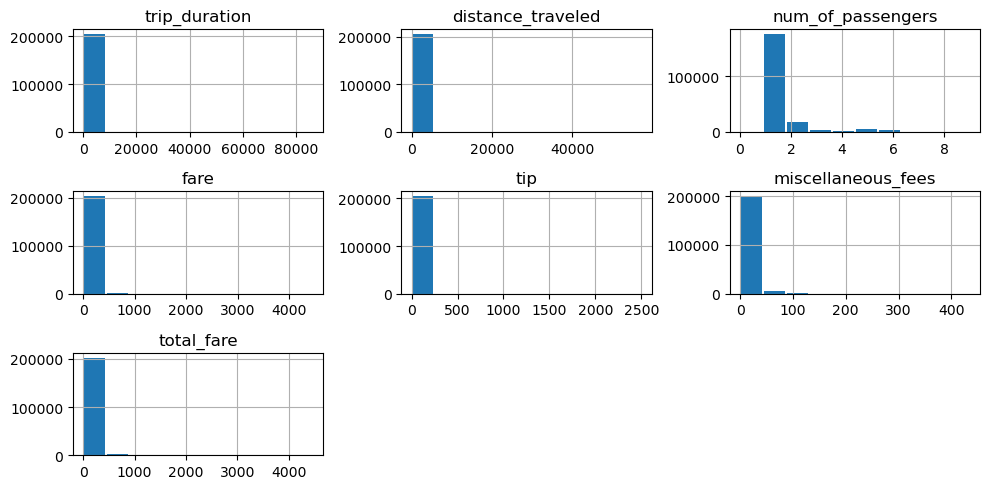

In [14]:
train_df1.hist(rwidth=0.9, figsize=(10,5))
plt.tight_layout();

### Transforming Input Features:

In [15]:
train_df1['trip_duration'] = np.sqrt(train_df1['trip_duration'])
train_df1['distance_traveled'] = np.log(train_df1['distance_traveled'])
train_df1['num_of_passengers'] = np.cbrt(train_df1['num_of_passengers'])
# train_df1['fare'] = np.sqrt(train_df1['fare'])
train_df1['tip'] = np.sqrt(train_df1['tip'])
# train_df1['miscellaneous_fees'] = np.sqrt(train_df1['miscellaneous_fees'])

### Transforming Target Feature:

In [16]:
train_df1['total_fare'] = np.sqrt(train_df1['total_fare'])

### Histogram After Transformation:

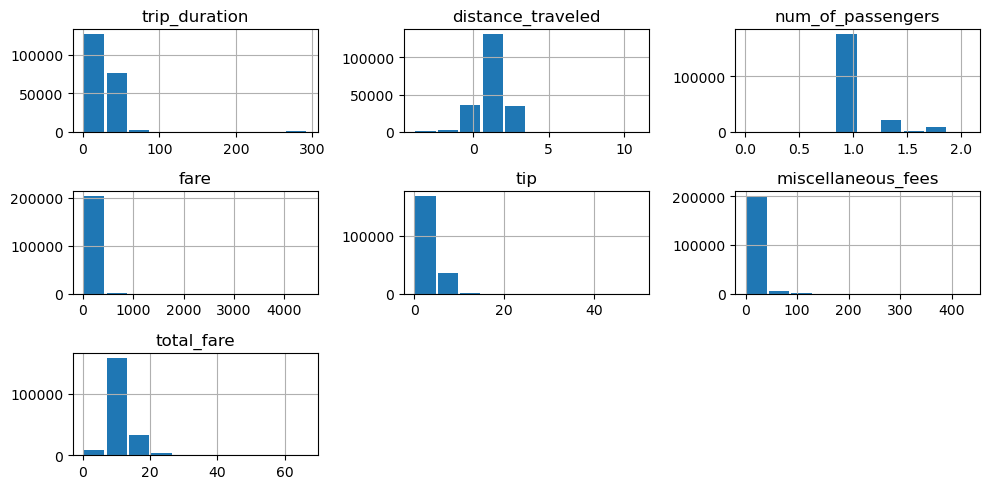

In [17]:
train_df1.hist(rwidth=0.9, figsize=(10,5))
plt.tight_layout();

### Due to this transformation, some Nan value got generated ?

In [18]:
train_df1.isna().sum()

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

### Scatterplot wrt all input features:

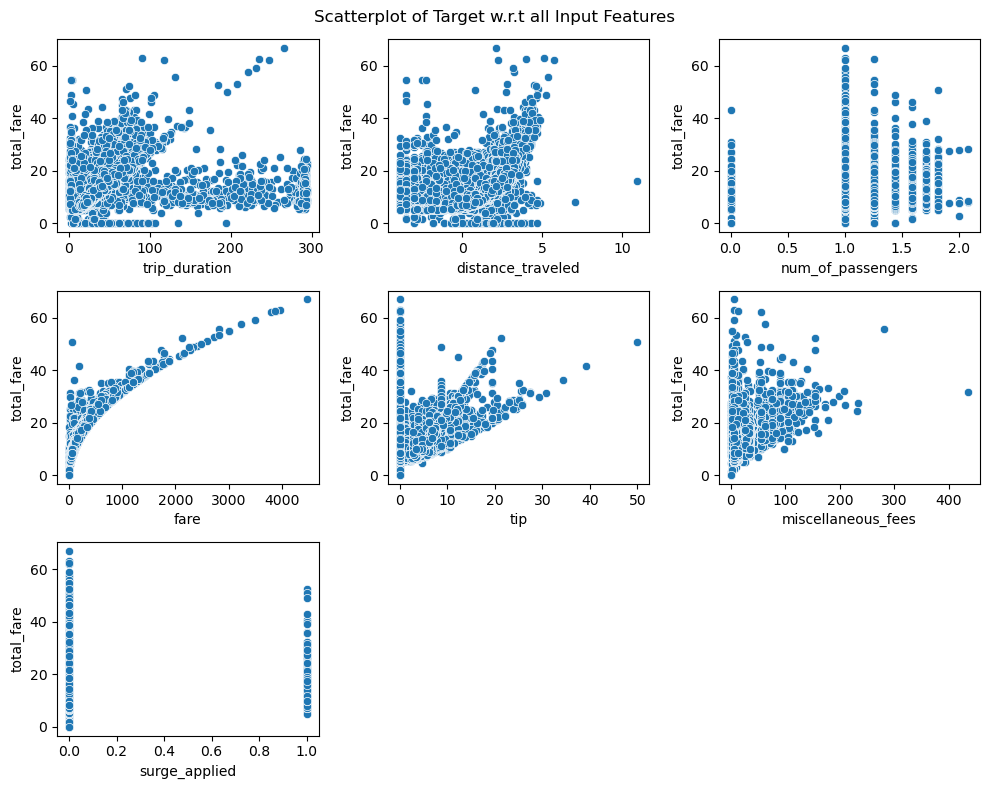

In [19]:
plt.figure(figsize=(10,8))
for i in range(0,len(input_features)):
    axi = plt.subplot(3,3,(i+1))
    sns.scatterplot(data=train_df1, x=input_features[i], y=target_feature, ax=axi)
plt.suptitle('Scatterplot of Target w.r.t all Input Features')
plt.tight_layout();

### Correlation Matrix:

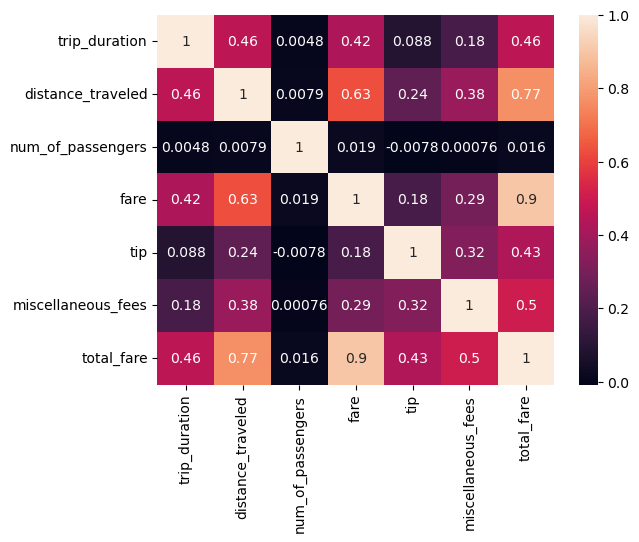

In [20]:
sns.heatmap(train_df1.corr(), annot=True);

### lets drop the fare column from train dataset:

In [21]:
train_df1.drop('fare', axis=1, inplace=True)

### Now lets again check the Multicollinearity!!

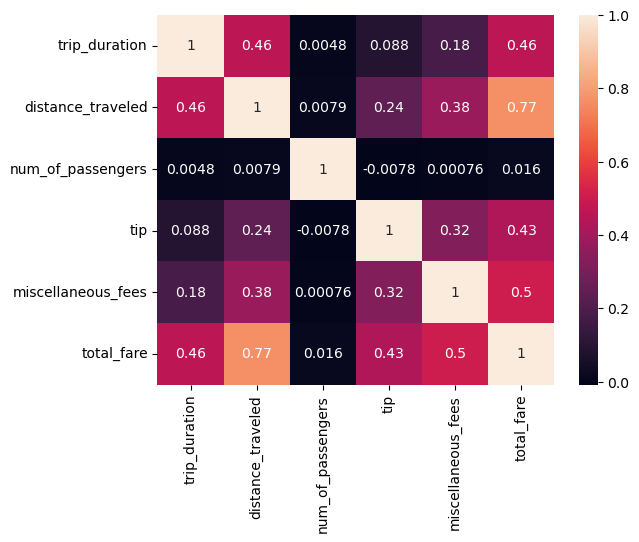

In [22]:
sns.heatmap(train_df1.corr(), annot=True);

### Outlier Handling for Train Data:

### Univariate Outlier Analysis:

number of records dropped =  7406


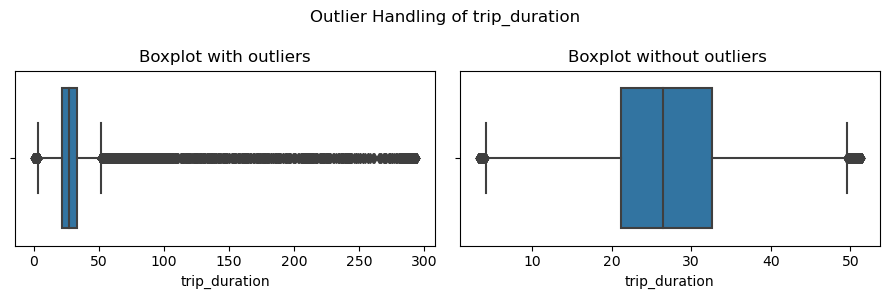

In [23]:
plt.figure(figsize=(9,3))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=train_df1, x='trip_duration', ax=ax1)
ax1.set_title('Boxplot with outliers');
q1 = np.quantile(train_df1['trip_duration'], 0.25)
q3 = np.quantile(train_df1['trip_duration'], 0.75)
iqr = q3 - q1
upper_quartile = q3 + (1.5*iqr)
lower_quartile = q1 - (1.5*iqr)
outliers_count = len(train_df1[train_df1['trip_duration'] > upper_quartile].index) + \
                 len(train_df1[train_df1['trip_duration'] < lower_quartile].index)
train_df1.drop(train_df1[train_df1['trip_duration'] > upper_quartile].index, inplace=True)
train_df1.drop(train_df1[train_df1['trip_duration'] < lower_quartile].index, inplace=True)
print('number of records dropped = ', outliers_count)
ax2 = plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='trip_duration')
ax2.set_title('Boxplot without outliers ')
plt.suptitle('Outlier Handling of trip_duration')
plt.tight_layout();

number of records dropped =  3060


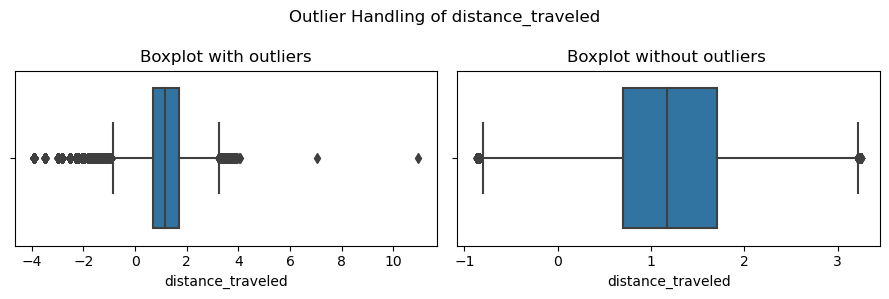

In [24]:
plt.figure(figsize=(9,3))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=train_df1, x='distance_traveled', ax=ax1)
ax1.set_title('Boxplot with outliers');
q1 = np.quantile(train_df1['distance_traveled'], 0.25)
q3 = np.quantile(train_df1['distance_traveled'], 0.75)
iqr = q3 - q1
upper_quartile = q3 + (1.5*iqr)
lower_quartile = q1 - (1.5*iqr)
outliers_count = len(train_df1[train_df1['distance_traveled'] > upper_quartile].index) + \
                 len(train_df1[train_df1['distance_traveled'] < lower_quartile].index)
train_df1.drop(train_df1[train_df1['distance_traveled'] > upper_quartile].index, inplace=True)
train_df1.drop(train_df1[train_df1['distance_traveled'] < lower_quartile].index, inplace=True)
print('number of records dropped = ', outliers_count)
ax2 = plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='distance_traveled')
ax2.set_title('Boxplot without outliers ')
plt.suptitle('Outlier Handling of distance_traveled')
plt.tight_layout();

number of records dropped =  28437


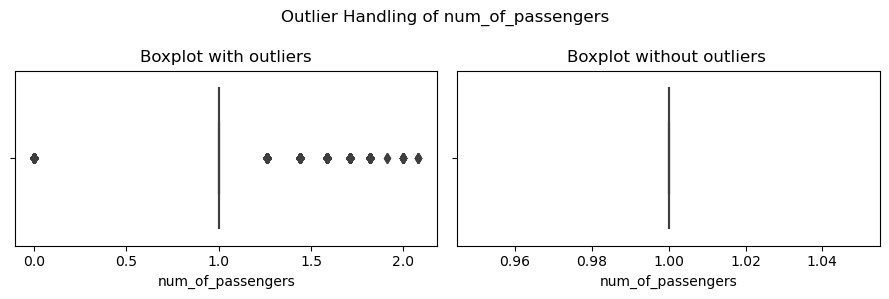

In [25]:
plt.figure(figsize=(9,3))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=train_df1, x='num_of_passengers', ax=ax1)
ax1.set_title('Boxplot with outliers');
q1 = np.quantile(train_df1['num_of_passengers'], 0.25)
q3 = np.quantile(train_df1['num_of_passengers'], 0.75)
iqr = q3 - q1
upper_quartile = q3 + (1.5*iqr)
lower_quartile = q1 - (1.5*iqr)
outliers_count = len(train_df1[train_df1['num_of_passengers'] > upper_quartile].index) + \
                 len(train_df1[train_df1['num_of_passengers'] < lower_quartile].index)
train_df1.drop(train_df1[train_df1['num_of_passengers'] > upper_quartile].index, inplace=True)
train_df1.drop(train_df1[train_df1['num_of_passengers'] < lower_quartile].index, inplace=True)
print('number of records dropped = ', outliers_count)
ax2 = plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='num_of_passengers')
ax2.set_title('Boxplot without outliers ')
plt.suptitle('Outlier Handling of num_of_passengers')
plt.tight_layout();

number of records dropped =  150


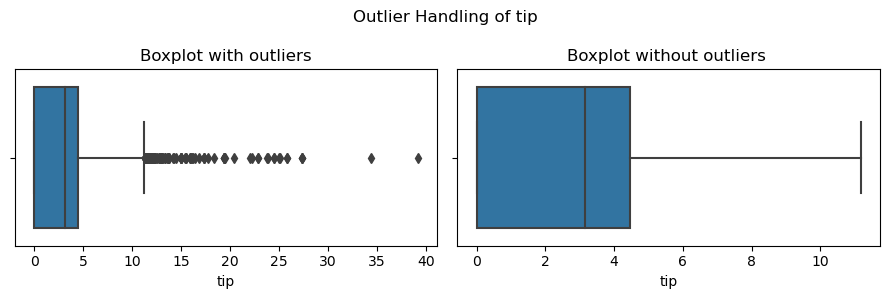

In [26]:
plt.figure(figsize=(9,3))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=train_df1, x='tip', ax=ax1)
ax1.set_title('Boxplot with outliers');
q1 = np.quantile(train_df1['tip'], 0.25)
q3 = np.quantile(train_df1['tip'], 0.75)
iqr = q3 - q1
upper_quartile = q3 + (1.5*iqr)
outliers_count = len(train_df1[train_df1['tip'] > upper_quartile].index)
train_df1.drop(train_df1[train_df1['tip'] > upper_quartile].index, inplace=True)
print('number of records dropped = ', outliers_count)
ax2 = plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='tip')
ax2.set_title('Boxplot without outliers ')
plt.suptitle('Outlier Handling of tip')
plt.tight_layout();

number of records dropped =  1230


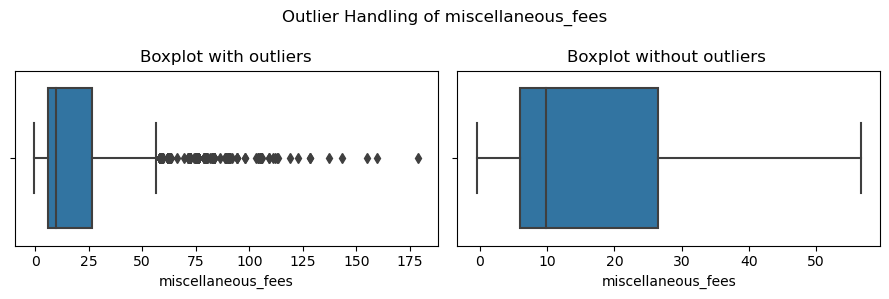

In [27]:
plt.figure(figsize=(9,3))
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=train_df1, x='miscellaneous_fees', ax=ax1)
ax1.set_title('Boxplot with outliers');
q1 = np.quantile(train_df1['miscellaneous_fees'], 0.25)
q3 = np.quantile(train_df1['miscellaneous_fees'], 0.75)
iqr = q3 - q1
upper_quartile = q3 + (1.5*iqr)
lower_quartile = q1 - (1.5*iqr)
outliers_count = len(train_df1[train_df1['miscellaneous_fees'] > upper_quartile].index) + \
                 len(train_df1[train_df1['miscellaneous_fees'] < lower_quartile].index)
train_df1.drop(train_df1[train_df1['miscellaneous_fees'] > upper_quartile].index, inplace=True)
train_df1.drop(train_df1[train_df1['miscellaneous_fees'] < lower_quartile].index, inplace=True)
print('number of records dropped = ', outliers_count)
ax2 = plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='miscellaneous_fees')
ax2.set_title('Boxplot without outliers ')
plt.suptitle('Outlier Handling of miscellaneous_fees')
plt.tight_layout();

### Boxplot for Target Feature:

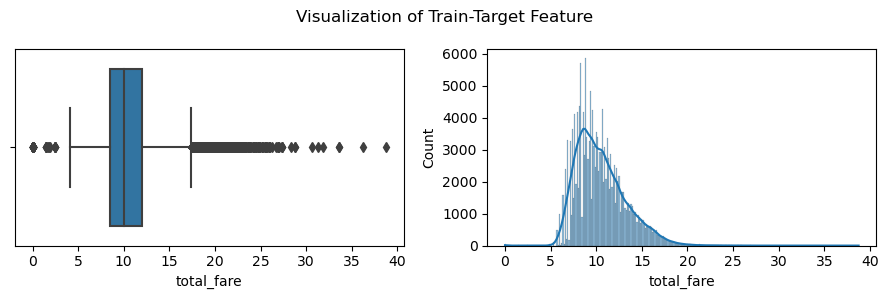

In [28]:
plt.figure(figsize=(9,3))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(data=train_df1, x='total_fare', ax=ax1)
sns.histplot(data=train_df1, x='total_fare', ax=ax2, kde=True)
plt.suptitle('Visualization of Train-Target Feature')
plt.tight_layout();

### Importing Test Dataset:

In [29]:
test_df = pd.read_csv('test.csv')
test_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0


### Preprocessing of Test Data:

In [30]:
# size of test data:
test_df.shape

(89861, 8)

In [31]:
# different datatypes present inside test data:
test_df.dtypes.value_counts()

float64    4
int64      4
dtype: int64

In [32]:
# changing datatype of surge_applied to category:
test_df['surge_applied'] = test_df['surge_applied'].astype('category')
test_df.dtypes

trip_duration          float64
distance_traveled      float64
num_of_passengers      float64
fare                     int64
tip                      int64
miscellaneous_fees     float64
total_fare               int64
surge_applied         category
dtype: object

In [33]:
# checking for null values:
test_df.isna().sum(axis=0)

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

In [34]:
# Checking for duplicate rows:
test_df.duplicated(keep='first').sum()

1231

In [35]:
# Which one are the duplicate rows:
test_df[test_df.duplicated(keep='first')]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
2088,602.0,2.41,1.0,0,0,6.00,0,0
2171,263.0,1.29,1.0,0,0,9.75,0,0
2532,2.0,0.03,1.0,0,0,2.25,0,0
3296,450.0,1.88,1.0,0,0,6.00,0,0
3337,446.0,1.54,1.0,0,0,6.00,0,0
...,...,...,...,...,...,...,...,...
89739,610.0,3.22,1.0,0,0,6.00,0,0
89754,470.0,1.83,1.0,0,12,5.70,0,0
89804,434.0,2.48,1.0,0,0,6.00,0,0
89817,411.0,1.58,1.0,0,14,5.65,0,0


we will not remove these duplicate rows

In [36]:
# Creating a copy of test dataframe:
print('test dataset has {} rows and {} columns' .format(test_df.shape[0], test_df.shape[1]))
test_df1 = test_df.copy()

test dataset has 89861 rows and 8 columns


In [37]:
# Statistical Description of test data:
test_df1.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare
count,89861.000000,89861.000000,89861.000000,89861.0,89861.000000,89861.000000,89861.0
mean,1148.178164,7.263529,1.286732,0.0,13.031048,15.190636,0.0
std,4611.480867,554.965869,0.920910,0.0,18.692751,12.677904,0.0
min,0.000000,0.020000,0.000000,0.0,0.000000,-0.500000,0.0
25%,446.000000,1.950000,1.000000,0.0,0.000000,6.000000,0.0
50%,705.000000,3.200000,1.000000,0.0,9.000000,9.750000,0.0
75%,1094.000000,5.730000,1.000000,0.0,20.000000,26.450000,0.0
max,86395.000000,145517.600000,9.000000,0.0,719.000000,431.500000,0.0


In [38]:
# dropping fare columns:
test_df1.drop('fare', axis=1, inplace=True)

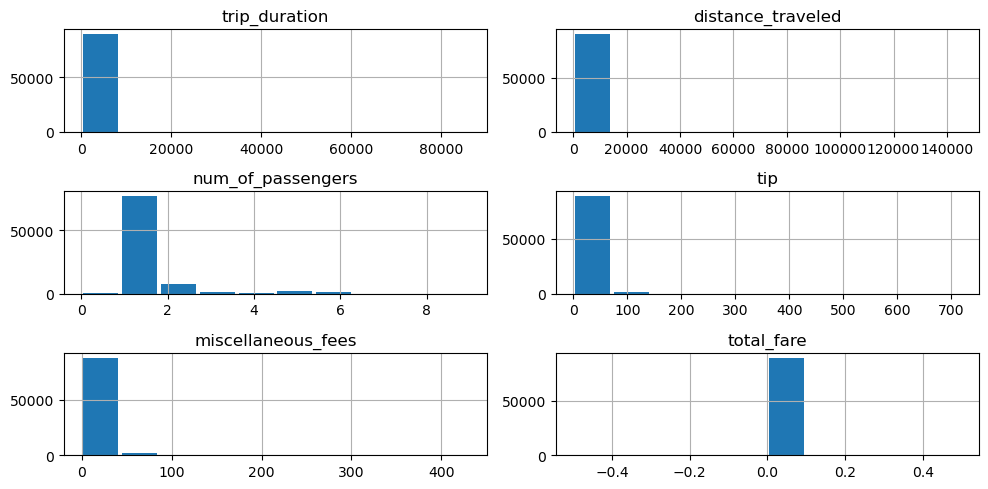

In [39]:
# Histogram for Test Data:
test_df1.hist(rwidth=0.9, figsize=(10,5))
plt.tight_layout();

In [40]:
# Transforming Input Features:
test_df1['trip_duration'] = np.sqrt(test_df1['trip_duration'])
test_df1['distance_traveled'] = np.log(test_df1['distance_traveled'])
test_df1['num_of_passengers'] = np.cbrt(test_df1['num_of_passengers'])
# test_df1['fare'] = np.sqrt(test_df1['fare'])
test_df1['tip'] = np.sqrt(test_df1['tip'])

In [41]:
# Did this transformation generated some NaN values?
test_df1.isna().sum()

trip_duration         0
distance_traveled     0
num_of_passengers     0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

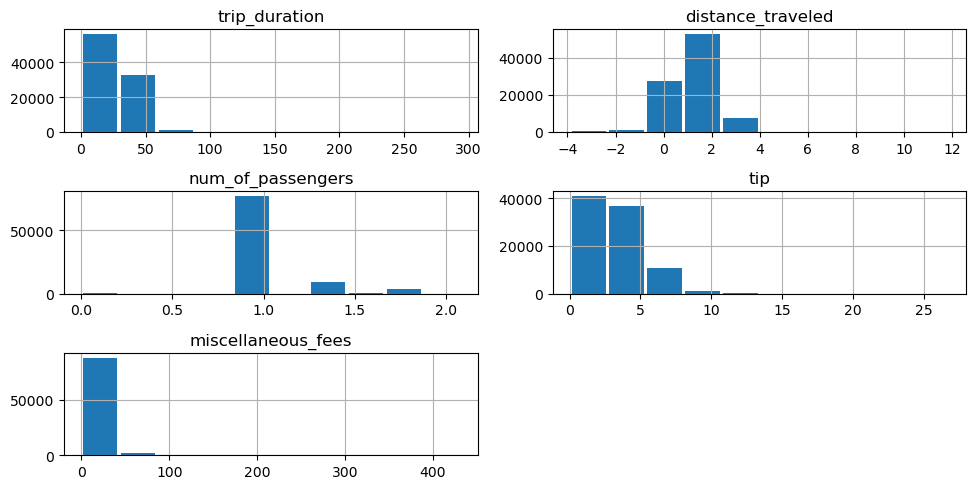

In [42]:
# Histogram after Transformation:
selected_cols = ['trip_duration', 'distance_traveled', 'num_of_passengers', 'tip', 
                 'miscellaneous_fees', 'surge_applied']
test_df1[selected_cols].hist(rwidth=0.9, figsize=(10,5))
plt.tight_layout();

### Seperating input & output feature from Train Dataset:

In [43]:
y = train_df1['total_fare']
x = train_df1.drop('total_fare', axis=1)

In [44]:
display(x.head())
print('Size of x = ', x.shape)

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,27.349589,1.011601,1.0,4.898979,6.300,0
1,34.452866,1.232560,1.0,4.898979,13.200,0
2,27.018512,1.137833,1.0,0.000000,26.625,1
4,18.138357,0.737164,1.0,3.464102,13.200,0
5,18.841444,0.553885,1.0,0.000000,26.625,1


Size of x =  (165065, 6)


In [45]:
display(y.head())
print('Size of y = ', y.shape)

0    10.261579
1    11.924764
2     9.893179
4     8.378544
5     8.463155
Name: total_fare, dtype: float64

Size of y =  (165065,)


In [46]:
y_test = test_df1['total_fare']   # we have to predict y_test
x_test = test_df1.drop('total_fare', axis=1)

In [47]:
display(x_test.head())
print('Size of x_test = ', x_test.shape)

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,32.802439,1.430311,1.000000,0.000000,13.500,0
1,20.712315,0.392042,1.587401,0.000000,13.500,0
2,29.257478,1.423108,1.000000,4.898979,6.000,0
3,24.939928,1.169381,1.000000,3.872983,5.625,0
4,22.516660,1.381282,1.000000,0.000000,2.250,0


Size of x_test =  (89861, 6)


In [48]:
# we have to predict y_test:
display(y_test.head())
print('Size of y_test = ', y_test.shape)

0    0
1    0
2    0
3    0
4    0
Name: total_fare, dtype: int64

Size of y_test =  (89861,)


### Creation of Validation Set:

In [49]:
x_train, x_validation, y_train, y_validation = train_test_split(x,y,test_size=0.3,random_state=1234)

In [50]:
display(x_train.head())
print(x_train.shape)

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
185801,23.537205,0.524729,1.0,0.000000,13.5,0
165689,18.248288,0.672944,1.0,3.162278,6.2,0
54592,16.822604,0.122218,1.0,0.000000,6.0,0
66877,40.496913,2.004179,1.0,0.000000,6.0,0
135512,11.090537,0.148420,1.0,0.000000,6.0,0


(115545, 6)


In [51]:
display(y_train.head())
print(y_train.shape)

185801     8.351647
165689     7.823043
54592      6.873864
66877     12.338963
135512     6.000000
Name: total_fare, dtype: float64

(115545,)


In [52]:
display(x_validation.head())
print(x_validation.shape)

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
99941,29.495762,1.376244,1.0,0.000000,6.000,0
85669,14.764823,0.378436,1.0,3.000000,5.700,0
2468,13.964240,0.029559,1.0,3.605551,5.750,0
82196,33.585711,1.613430,1.0,5.196152,26.700,1
190098,34.481879,1.532557,1.0,0.000000,34.125,1


(49520, 6)


In [53]:
display(y_validation.head())
print(y_validation.shape)

99941      9.797959
85669      7.224957
2468       7.245688
82196     12.745587
190098    11.953033
Name: total_fare, dtype: float64

(49520,)


### Normalization of x_train:

In [54]:
scaler = MinMaxScaler()
filtered_cols = ['trip_duration','distance_traveled','num_of_passengers','tip',
                 'miscellaneous_fees']
x_train[filtered_cols] = scaler.fit_transform(x_train[filtered_cols])
x_train.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
185801,0.421210,0.338349,0.0,0.000000,0.245614,0
165689,0.311038,0.374370,0.0,0.282843,0.117544,0
54592,0.281340,0.240528,0.0,0.000000,0.114035,0
66877,0.774494,0.697896,0.0,0.000000,0.114035,0
135512,0.161937,0.246896,0.0,0.000000,0.114035,0


### Normalization of x_validation:

In [55]:
x_validation[filtered_cols] = scaler.transform(x_validation[filtered_cols])
x_validation.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
99941,0.545332,0.545290,0.0,0.000000,0.114035,0
85669,0.238475,0.302796,0.0,0.268328,0.108772,0
2468,0.221798,0.218010,0.0,0.322490,0.109649,0
82196,0.630529,0.602933,0.0,0.464758,0.477193,1
190098,0.649197,0.583279,0.0,0.000000,0.607456,1


### Normalization of x_test:

In [56]:
x_test[filtered_cols] = scaler.transform(x_test[filtered_cols])
x_test.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,0.614212,0.558430,0.000000,0.000000,0.245614,0
1,0.362366,0.306103,0.587401,0.000000,0.245614,0
2,0.540368,0.556680,0.000000,0.438178,0.114035,0
3,0.450430,0.495017,0.000000,0.346410,0.107456,0
4,0.399952,0.546515,0.000000,0.000000,0.048246,0


# Model Implementation:

In [57]:
x_train['surge_applied'] = x_train['surge_applied'].astype('int')
x_validation['surge_applied'] = x_validation['surge_applied'].astype('int')
x_test['surge_applied'] = x_test['surge_applied'].astype('int')

## Linear Regression Model:

In [58]:
x_train_mod = sm.add_constant(x_train)
ols = sm.OLS(y_train, x_train_mod)
result = ols.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             total_fare   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 2.309e+05
Date:                Fri, 09 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:39:38   Log-Likelihood:            -1.4031e+05
No. Observations:              115545   AIC:                         2.806e+05
Df Residuals:                  115539   BIC:                         2.807e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.7299      0.008    328.920      0.000       2.714       2.746
trip_duration          5.8518      0.025    233.415      0.000       5.803       5.901
distance_traveled      7.0979      0.025    288.699      0.000       7.050       7.146
num_of_passengers   1.338e-15   5.41e-17     24.742      0.000    1.23e-15    1.44e-15
tip                    2.7812      0.012    231.766      0.000       2.758       2.805
miscellaneous_fees     2.5168      0.024    103.733      0.000       2.469       2.564
surge_applied         -0.1075      0.010    -10.846      0.000      -0.127      -0.088
==============================================================================
Omnibus:                   132426.863   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         54223712.834
Skew:                           5.478   Prob(JB):                         0.00
Kurtosis:                     108.560   Cond. No.                     2.50e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.25e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

OLS is not reliable here

In [59]:
y_pred_mlr = result.predict(sm.add_constant(x_validation))
mlr_score = np.round(r2_score(y_validation, y_pred_mlr),4)

no_of_rows = x_validation.shape[0]
tot_no_of_input_cols = x_validation.shape[1]
mlr_adj_r2_score = 1 - ((1-mlr_score)*(no_of_rows)/(no_of_rows - tot_no_of_input_cols - 1))

# mlr_train_r2 = 0.142
mlr_rmse = np.round(np.sqrt(mean_squared_error(y_validation,y_pred_mlr)),2)

print('Model RMSE Value       = ', mlr_rmse)
print('Test R2 score          = ', mlr_score)
print('Test Adjusted R2-score = ', np.round(mlr_adj_r2_score,4))

Model RMSE Value       =  0.86
Test R2 score          =  0.8992
Test Adjusted R2-score =  0.8992


### Prediction on Test Data:

In [60]:
y_test_lr = result.predict(sm.add_constant(x_test))
op1 = np.square(y_test_lr)
# print(op1)
print('length = ', len(op1))

length =  89861


## Random Forest:

In [61]:
rf = RandomForestRegressor(min_samples_split=10,random_state=1234)
rf.fit(x_train, y_train)
y_pred_rf_test = rf.predict(x_validation)
rf_train_accuracy = rf.score(x_train, y_train)
rf_test_accuracy = rf.score(x_validation, y_validation)
rf2_rmse = np.sqrt(mean_squared_error(y_validation, y_pred_rf_test))
rf2_rmsle = np.sqrt(mean_squared_log_error(y_validation, y_pred_rf_test))
print('Train Score = ', rf_train_accuracy)
print('Test Score  = ', rf_test_accuracy)
print('RMSE value  = ', rf2_rmse)
print('RMSLE       = ', rf2_rmsle)

# min_samples_split=9
# Train Score =  0.9852619300274875
# Test Score  =  0.9616413837042798
# RMSE value  =  0.5312130584967973
# RMSLE       =  0.05109398296274033

# min_samples_split=10
# Train Score =  0.9846477320519716
# Test Score  =  0.9616225431233016
# RMSE value  =  0.5313435002979213
# RMSLE       =  0.051091822092548506

Train Score =  0.9846477320519716
Test Score  =  0.9616225431233016
RMSE value  =  0.5313435002979213
RMSLE       =  0.051091822092548506


### Writing into csv file (best score obtained):

In [62]:
y_pred_rf2 = rf.predict(x_test)
op2 = np.square(y_pred_rf2)
answer = pd.DataFrame()
answer['total_fare'] = op2
answer.to_csv('submission.csv', index=False)

### HyperParamter Tuning in Random Forest:

In [63]:
rf1 = RandomForestRegressor(n_estimators= 50,
                            min_samples_split= 9, 
                            min_samples_leaf=4,
                            max_depth=18,
                            random_state=256)
rf1.fit(x_train, y_train)
y_pred_rf1_test = rf1.predict(x_validation)
rf1_train_accuracy = rf1.score(x_train, y_train)
rf1_test_accuracy = rf1.score(x_validation, y_validation)
rf1_rmse = np.sqrt(mean_squared_error(y_validation, y_pred_rf_test))
rf1_rmsle = np.sqrt(mean_squared_log_error(y_validation, y_pred_rf_test))
print('Train Score = ', rf1_train_accuracy)
print('Test Score  = ', rf1_test_accuracy)
print('RMSE value  = ', rf1_rmse)
print('RMSLE       = ', rf1_rmsle)

Train Score =  0.978530467104578
Test Score  =  0.9611990817632389
RMSE value  =  0.5313435002979213
RMSLE       =  0.051091822092548506


### Writing output into csv file:

In [64]:
y_pred_rf3 = rf1.predict(x_test)
op3 = np.square(y_pred_rf3)
answer1 = pd.DataFrame()
answer1['total_fare'] = op3
answer1.to_csv('submission1.csv', index=False)

### XgBoost Regressor:

In [65]:
# param_grid = {"max_depth":    [4, 5, 6],
#               "n_estimators": [500, 600, 700],
#               "learning_rate": [0.01, 0.015]}
# search = RandomizedSearchCV(regressor, param_grid, cv=5).fit(x_train, y_train)
# print("The best hyperparameters are ",search.best_params_)

In [66]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')
regressor=xgb.XGBRegressor(learning_rate = 0.015,
                           n_estimators  = 800,
                           max_depth     = 6,
                           eval_metric='rmsle', 
                           random_state=1234)


regressor.fit(x_train, y_train)
predictions = regressor.predict(x_validation)
xg1_rmsle = np.sqrt(mean_squared_log_error(y_validation, predictions))
xg1_train_accuracy = regressor.score(x_train, y_train)
xg1_test_accuracy = regressor.score(x_validation, y_validation)
print('Train Score = ', xg1_train_accuracy)
print('Test Score  = ', xg1_test_accuracy)
print('RMSLE = ', xg1_rmsle)


# Train Score =  0.9808218086300182
# Test Score  =  0.9642334011144377
# RMSLE =  0.04886259659795007

Train Score =  0.9808218086300182
Test Score  =  0.9642334011144377
RMSLE =  0.04886259659795007


### writing output inside csv file:

In [67]:
y_pred_xg = regressor.predict(x_test)
op4 = np.square(y_pred_xg)
answer2 = pd.DataFrame()
answer2['total_fare'] = op4
answer2.to_csv('submission2.csv', index=False)

### LightGBM:

In [68]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [69]:
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(x_train, y_train,
        eval_set=[(x_validation, y_validation)],
        eval_metric='rmsle',
        early_stopping_rounds=1000)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.

[149]	valid_0's l1: 1.06286	valid_0's l2: 1.95842
[150]	valid_0's l1: 1.05797	valid_0's l2: 1.94247
[151]	valid_0's l1: 1.05311	valid_0's l2: 1.92672
[152]	valid_0's l1: 1.04827	valid_0's l2: 1.91113
[153]	valid_0's l1: 1.04346	valid_0's l2: 1.89569
[154]	valid_0's l1: 1.03866	valid_0's l2: 1.88039
[155]	valid_0's l1: 1.03389	valid_0's l2: 1.86524
[156]	valid_0's l1: 1.02914	valid_0's l2: 1.85025
[157]	valid_0's l1: 1.02441	valid_0's l2: 1.83539
[158]	valid_0's l1: 1.0197	valid_0's l2: 1.82067
[159]	valid_0's l1: 1.01503	valid_0's l2: 1.80615
[160]	valid_0's l1: 1.01038	valid_0's l2: 1.79176
[161]	valid_0's l1: 1.00574	valid_0's l2: 1.77747
[162]	valid_0's l1: 1.00114	valid_0's l2: 1.76333
[163]	valid_0's l1: 0.996553	valid_0's l2: 1.74931
[164]	valid_0's l1: 0.99199	valid_0's l2: 1.7354
[165]	valid_0's l1: 0.987463	valid_0's l2: 1.72169
[166]	valid_0's l1: 0.982923	valid_0's l2: 1.70803
[167]	valid_0's l1: 0.978441	valid_0's l2: 1.69453
[168]	valid_0's l1: 0.973944	valid_0's l2: 1.681

[319]	valid_0's l1: 0.501542	valid_0's l2: 0.620574
[320]	valid_0's l1: 0.499482	valid_0's l2: 0.617416
[321]	valid_0's l1: 0.497423	valid_0's l2: 0.614328
[322]	valid_0's l1: 0.495368	valid_0's l2: 0.611205
[323]	valid_0's l1: 0.493321	valid_0's l2: 0.608134
[324]	valid_0's l1: 0.491287	valid_0's l2: 0.605072
[325]	valid_0's l1: 0.489262	valid_0's l2: 0.602043
[326]	valid_0's l1: 0.487256	valid_0's l2: 0.599084
[327]	valid_0's l1: 0.485249	valid_0's l2: 0.596132
[328]	valid_0's l1: 0.483256	valid_0's l2: 0.593203
[329]	valid_0's l1: 0.481281	valid_0's l2: 0.590307
[330]	valid_0's l1: 0.479302	valid_0's l2: 0.587391
[331]	valid_0's l1: 0.477334	valid_0's l2: 0.584533
[332]	valid_0's l1: 0.47538	valid_0's l2: 0.581709
[333]	valid_0's l1: 0.473433	valid_0's l2: 0.578912
[334]	valid_0's l1: 0.471498	valid_0's l2: 0.576136
[335]	valid_0's l1: 0.469581	valid_0's l2: 0.573397
[336]	valid_0's l1: 0.467668	valid_0's l2: 0.57067
[337]	valid_0's l1: 0.465763	valid_0's l2: 0.567984
[338]	valid_0'

[479]	valid_0's l1: 0.278832	valid_0's l2: 0.356136
[480]	valid_0's l1: 0.277989	valid_0's l2: 0.355408
[481]	valid_0's l1: 0.277141	valid_0's l2: 0.354701
[482]	valid_0's l1: 0.276298	valid_0's l2: 0.353996
[483]	valid_0's l1: 0.275459	valid_0's l2: 0.353297
[484]	valid_0's l1: 0.274624	valid_0's l2: 0.352602
[485]	valid_0's l1: 0.2738	valid_0's l2: 0.351916
[486]	valid_0's l1: 0.272979	valid_0's l2: 0.351236
[487]	valid_0's l1: 0.272158	valid_0's l2: 0.35056
[488]	valid_0's l1: 0.271343	valid_0's l2: 0.349884
[489]	valid_0's l1: 0.270523	valid_0's l2: 0.349178
[490]	valid_0's l1: 0.269726	valid_0's l2: 0.348495
[491]	valid_0's l1: 0.268927	valid_0's l2: 0.347851
[492]	valid_0's l1: 0.268132	valid_0's l2: 0.347197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's l1: 0.267349	valid_0's l2: 0.346555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's l1: 0.266572	valid_0's l2: 0.345924
[LightGBM] [Warning] 

[576]	valid_0's l1: 0.217194	valid_0's l2: 0.309009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[577]	valid_0's l1: 0.216755	valid_0's l2: 0.308729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's l1: 0.216315	valid_0's l2: 0.308429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[579]	valid_0's l1: 0.21588	valid_0's l2: 0.308152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's l1: 0.215451	valid_0's l2: 0.307872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	valid_0's l1: 0.215018	valid_0's l2: 0.30757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[582]	valid_0's l1: 0.214589	valid_0's l2: 0.307271
[583]	valid_0's l1: 0.214153	valid_0's l2: 0.306974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[584]	valid_0's l1: 0.213725	valid_0's l2: 0.306675
[LightGBM

[645]	valid_0's l1: 0.192822	valid_0's l2: 0.291523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[646]	valid_0's l1: 0.192561	valid_0's l2: 0.291348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[647]	valid_0's l1: 0.192302	valid_0's l2: 0.291186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[648]	valid_0's l1: 0.192042	valid_0's l2: 0.291012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[649]	valid_0's l1: 0.191784	valid_0's l2: 0.29085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[650]	valid_0's l1: 0.191528	valid_0's l2: 0.290674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[651]	valid_0's l1: 0.191281	valid_0's l2: 0.290475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[652]	valid_0's l1: 0.191037	valid_0's l2: 0.290278
[LightGBM] [Warning] No further splits with positive gain, b

[725]	valid_0's l1: 0.177052	valid_0's l2: 0.280447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's l1: 0.176905	valid_0's l2: 0.280358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's l1: 0.176762	valid_0's l2: 0.28028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's l1: 0.176628	valid_0's l2: 0.280203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's l1: 0.176498	valid_0's l2: 0.280134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's l1: 0.176354	valid_0's l2: 0.280047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's l1: 0.176222	valid_0's l2: 0.279947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's l1: 0.176091	valid_0's l2: 0.279849
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[804]	valid_0's l1: 0.168921	valid_0's l2: 0.27458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	valid_0's l1: 0.168855	valid_0's l2: 0.274542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	valid_0's l1: 0.168789	valid_0's l2: 0.274508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's l1: 0.168723	valid_0's l2: 0.274471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's l1: 0.168658	valid_0's l2: 0.274438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	valid_0's l1: 0.168595	valid_0's l2: 0.274407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	valid_0's l1: 0.168531	valid_0's l2: 0.274374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's l1: 0.168459	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	valid_0's l1: 0.164949	valid_0's l2: 0.271597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's l1: 0.164911	valid_0's l2: 0.271565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's l1: 0.164873	valid_0's l2: 0.271538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's l1: 0.164835	valid_0's l2: 0.271507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's l1: 0.164795	valid_0's l2: 0.271465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's l1: 0.164756	valid_0's l2: 0.271424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's l1: 0.164717	valid_0's l2: 0.271383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's l1: 0.164678	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	valid_0's l1: 0.162431	valid_0's l2: 0.269243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	valid_0's l1: 0.162417	valid_0's l2: 0.269228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	valid_0's l1: 0.162403	valid_0's l2: 0.269214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	valid_0's l1: 0.162389	valid_0's l2: 0.269203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's l1: 0.162374	valid_0's l2: 0.26919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[969]	valid_0's l1: 0.162362	valid_0's l2: 0.269176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's l1: 0.162349	valid_0's l2: 0.269164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's l1: 0.162328	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1057]	valid_0's l1: 0.161048	valid_0's l2: 0.267313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1058]	valid_0's l1: 0.161031	valid_0's l2: 0.267282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1059]	valid_0's l1: 0.161016	valid_0's l2: 0.267252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1060]	valid_0's l1: 0.161	valid_0's l2: 0.267223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1061]	valid_0's l1: 0.160991	valid_0's l2: 0.267199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1062]	valid_0's l1: 0.160981	valid_0's l2: 0.267177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1063]	valid_0's l1: 0.160972	valid_0's l2: 0.267154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1064]	valid_0's l1: 0.160964	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's l1: 0.160199	valid_0's l2: 0.266026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1151]	valid_0's l1: 0.160193	valid_0's l2: 0.266008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1152]	valid_0's l1: 0.160188	valid_0's l2: 0.265987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1153]	valid_0's l1: 0.160183	valid_0's l2: 0.265966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1154]	valid_0's l1: 0.160179	valid_0's l2: 0.265949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's l1: 0.160176	valid_0's l2: 0.265952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's l1: 0.160169	valid_0's l2: 0.265931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's l1: 0.160167

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1248]	valid_0's l1: 0.159824	valid_0's l2: 0.264618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1249]	valid_0's l1: 0.159822	valid_0's l2: 0.264609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1250]	valid_0's l1: 0.159816	valid_0's l2: 0.264601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1251]	valid_0's l1: 0.159813	valid_0's l2: 0.264597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1252]	valid_0's l1: 0.15981	valid_0's l2: 0.264595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1253]	valid_0's l1: 0.159806	valid_0's l2: 0.264592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1254]	valid_0's l1: 0.159803	valid_0's l2: 0.26459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1255]	valid_0's l1: 0.1598	val

[1319]	valid_0's l1: 0.159606	valid_0's l2: 0.263972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1320]	valid_0's l1: 0.159602	valid_0's l2: 0.263959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1321]	valid_0's l1: 0.159599	valid_0's l2: 0.263956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's l1: 0.159597	valid_0's l2: 0.263952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's l1: 0.159594	valid_0's l2: 0.26395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's l1: 0.159591	valid_0's l2: 0.263949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's l1: 0.159588	valid_0's l2: 0.263946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's l1: 0.159585	valid_0's l2: 0.263945
[LightGBM] [Warning] No further splits with positive

[1392]	valid_0's l1: 0.159417	valid_0's l2: 0.263343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's l1: 0.159414	valid_0's l2: 0.263325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's l1: 0.159413	valid_0's l2: 0.263325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's l1: 0.159411	valid_0's l2: 0.263306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1396]	valid_0's l1: 0.159411	valid_0's l2: 0.263306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1397]	valid_0's l1: 0.159409	valid_0's l2: 0.263289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1398]	valid_0's l1: 0.159408	valid_0's l2: 0.263275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1399]	valid_0's l1: 0.159406	valid_0's l2: 0.263272
[LightGBM] [Warning] No further splits with positiv

[1464]	valid_0's l1: 0.159281	valid_0's l2: 0.262586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1465]	valid_0's l1: 0.159282	valid_0's l2: 0.262608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1466]	valid_0's l1: 0.159282	valid_0's l2: 0.262631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1467]	valid_0's l1: 0.159283	valid_0's l2: 0.262654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1468]	valid_0's l1: 0.159284	valid_0's l2: 0.262677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1469]	valid_0's l1: 0.159283	valid_0's l2: 0.262701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1470]	valid_0's l1: 0.159282	valid_0's l2: 0.262724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's l1: 0.159283	valid_0's l2: 0.262725
[LightGBM] [Warning] No further splits with positiv

[1538]	valid_0's l1: 0.15917	valid_0's l2: 0.262262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1539]	valid_0's l1: 0.159165	valid_0's l2: 0.262248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1540]	valid_0's l1: 0.159159	valid_0's l2: 0.262234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1541]	valid_0's l1: 0.159157	valid_0's l2: 0.26221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1542]	valid_0's l1: 0.159155	valid_0's l2: 0.262186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1543]	valid_0's l1: 0.159154	valid_0's l2: 0.262163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's l1: 0.159152	valid_0's l2: 0.26214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's l1: 0.159151	valid_0's l2: 0.262118
[LightGBM] [Warning] No further splits with positive g

[1618]	valid_0's l1: 0.159085	valid_0's l2: 0.261643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1619]	valid_0's l1: 0.159086	valid_0's l2: 0.261636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1620]	valid_0's l1: 0.159088	valid_0's l2: 0.261634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1621]	valid_0's l1: 0.15909	valid_0's l2: 0.26165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1622]	valid_0's l1: 0.159091	valid_0's l2: 0.261667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1623]	valid_0's l1: 0.159093	valid_0's l2: 0.261684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1624]	valid_0's l1: 0.159094	valid_0's l2: 0.261701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1625]	valid_0's l1: 0.159096	valid_0's l2: 0.261718
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1700]	valid_0's l1: 0.159094	valid_0's l2: 0.261297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1701]	valid_0's l1: 0.15909	valid_0's l2: 0.261282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1702]	valid_0's l1: 0.159087	valid_0's l2: 0.261277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1703]	valid_0's l1: 0.159084	valid_0's l2: 0.261272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1704]	valid_0's l1: 0.15908	valid_0's l2: 0.261267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1705]	valid_0's l1: 0.159077	valid_0's l2: 0.261263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1706]	valid_0's l1: 0.159074	valid_0's l2: 0.261258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1707]	valid_0's l1: 0.159071	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1776]	valid_0's l1: 0.15892	valid_0's l2: 0.260966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1777]	valid_0's l1: 0.158919	valid_0's l2: 0.26096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1778]	valid_0's l1: 0.158917	valid_0's l2: 0.260953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1779]	valid_0's l1: 0.158915	valid_0's l2: 0.260947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1780]	valid_0's l1: 0.158914	valid_0's l2: 0.260941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1781]	valid_0's l1: 0.158913	valid_0's l2: 0.260939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1782]	valid_0's l1: 0.15891	valid_0's l2: 0.260934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1783]	valid_0's l1: 0.158908	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1852]	valid_0's l1: 0.158878	valid_0's l2: 0.261181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1853]	valid_0's l1: 0.158879	valid_0's l2: 0.261191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1854]	valid_0's l1: 0.158879	valid_0's l2: 0.261201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1855]	valid_0's l1: 0.15888	valid_0's l2: 0.261211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1856]	valid_0's l1: 0.158881	valid_0's l2: 0.261219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1857]	valid_0's l1: 0.158882	valid_0's l2: 0.261227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1858]	valid_0's l1: 0.158883	valid_0's l2: 0.261237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1859]	valid_0's l1: 0.158884	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1932]	valid_0's l1: 0.158889	valid_0's l2: 0.261215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1933]	valid_0's l1: 0.158887	valid_0's l2: 0.261191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1934]	valid_0's l1: 0.158884	valid_0's l2: 0.261167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's l1: 0.158881	valid_0's l2: 0.261143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's l1: 0.158879	valid_0's l2: 0.26112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's l1: 0.158877	valid_0's l2: 0.261097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1938]	valid_0's l1: 0.158876	valid_0's l2: 0.261074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's l1: 0.158874	

[2006]	valid_0's l1: 0.158752	valid_0's l2: 0.260671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2007]	valid_0's l1: 0.158751	valid_0's l2: 0.260647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2008]	valid_0's l1: 0.158749	valid_0's l2: 0.260628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2009]	valid_0's l1: 0.158748	valid_0's l2: 0.260603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2010]	valid_0's l1: 0.158749	valid_0's l2: 0.260582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2011]	valid_0's l1: 0.158747	valid_0's l2: 0.260575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2012]	valid_0's l1: 0.158746	valid_0's l2: 0.260568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2013]	valid_0's l1: 0.158745	valid_0's l2: 0.260561
[LightGBM] [Warning] No further splits with positiv

[2083]	valid_0's l1: 0.158742	valid_0's l2: 0.260177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2084]	valid_0's l1: 0.158742	valid_0's l2: 0.26016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2085]	valid_0's l1: 0.158744	valid_0's l2: 0.260158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2086]	valid_0's l1: 0.158744	valid_0's l2: 0.260142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2087]	valid_0's l1: 0.158744	valid_0's l2: 0.260126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2088]	valid_0's l1: 0.158744	valid_0's l2: 0.26011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2089]	valid_0's l1: 0.158745	valid_0's l2: 0.260107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2090]	valid_0's l1: 0.158745	valid_0's l2: 0.260091
[LightGBM] [Warning] No further splits with positive 

[2164]	valid_0's l1: 0.158658	valid_0's l2: 0.259727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2165]	valid_0's l1: 0.158658	valid_0's l2: 0.259707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2166]	valid_0's l1: 0.158658	valid_0's l2: 0.259688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2167]	valid_0's l1: 0.158657	valid_0's l2: 0.259669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2168]	valid_0's l1: 0.158657	valid_0's l2: 0.25965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2169]	valid_0's l1: 0.158657	valid_0's l2: 0.259631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2170]	valid_0's l1: 0.158657	valid_0's l2: 0.259613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2171]	valid_0's l1: 0.158659	valid_0's l2: 0.259612
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2246]	valid_0's l1: 0.158641	valid_0's l2: 0.259779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2247]	valid_0's l1: 0.158644	valid_0's l2: 0.259789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2248]	valid_0's l1: 0.158646	valid_0's l2: 0.259798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2249]	valid_0's l1: 0.158648	valid_0's l2: 0.25981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2250]	valid_0's l1: 0.15865	valid_0's l2: 0.25982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2251]	valid_0's l1: 0.158651	valid_0's l2: 0.259825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2252]	valid_0's l1: 0.158652	valid_0's l2: 0.259831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2253]	valid_0's l1: 0.158653	va

[2332]	valid_0's l1: 0.158691	valid_0's l2: 0.260474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2333]	valid_0's l1: 0.158692	valid_0's l2: 0.260497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2334]	valid_0's l1: 0.158693	valid_0's l2: 0.26052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2335]	valid_0's l1: 0.158694	valid_0's l2: 0.260544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2336]	valid_0's l1: 0.158695	valid_0's l2: 0.260567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2337]	valid_0's l1: 0.158696	valid_0's l2: 0.260591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2338]	valid_0's l1: 0.158698	valid_0's l2: 0.260614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2339]	valid_0's l1: 0.158699	valid_0's l2: 0.260637
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2413]	valid_0's l1: 0.158719	valid_0's l2: 0.260596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2414]	valid_0's l1: 0.158721	valid_0's l2: 0.260596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2415]	valid_0's l1: 0.158722	valid_0's l2: 0.260596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2416]	valid_0's l1: 0.158723	valid_0's l2: 0.260593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2417]	valid_0's l1: 0.158724	valid_0's l2: 0.260593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2418]	valid_0's l1: 0.158725	valid_0's l2: 0.260591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2419]	valid_0's l1: 0.158725	valid_0's l2: 0.260591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2420]	valid_0's l1: 0.158726

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2491]	valid_0's l1: 0.158699	valid_0's l2: 0.260634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2492]	valid_0's l1: 0.158699	valid_0's l2: 0.260627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2493]	valid_0's l1: 0.158698	valid_0's l2: 0.260614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2494]	valid_0's l1: 0.158697	valid_0's l2: 0.260601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2495]	valid_0's l1: 0.158696	valid_0's l2: 0.260589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2496]	valid_0's l1: 0.158695	valid_0's l2: 0.260577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2497]	valid_0's l1: 0.158694	valid_0's l2: 0.260564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2498]	valid_0's l1: 0.158693

[2568]	valid_0's l1: 0.158681	valid_0's l2: 0.260135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2569]	valid_0's l1: 0.158681	valid_0's l2: 0.260128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2570]	valid_0's l1: 0.158683	valid_0's l2: 0.260123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2571]	valid_0's l1: 0.158686	valid_0's l2: 0.260144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2572]	valid_0's l1: 0.158689	valid_0's l2: 0.260165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2573]	valid_0's l1: 0.158692	valid_0's l2: 0.260185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2574]	valid_0's l1: 0.158692	valid_0's l2: 0.260198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2575]	valid_0's l1: 0.158695	valid_0's l2: 0.260218
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2652]	valid_0's l1: 0.158712	valid_0's l2: 0.260614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2653]	valid_0's l1: 0.158713	valid_0's l2: 0.260612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2654]	valid_0's l1: 0.158713	valid_0's l2: 0.260609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2655]	valid_0's l1: 0.158714	valid_0's l2: 0.260607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2656]	valid_0's l1: 0.158715	valid_0's l2: 0.260605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2657]	valid_0's l1: 0.158716	valid_0's l2: 0.260603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2658]	valid_0's l1: 0.158716	valid_0's l2: 0.260601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2659]	valid_0's l1: 0.158717

[2735]	valid_0's l1: 0.158762	valid_0's l2: 0.260872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2736]	valid_0's l1: 0.158764	valid_0's l2: 0.260876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2737]	valid_0's l1: 0.158766	valid_0's l2: 0.26088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2738]	valid_0's l1: 0.158766	valid_0's l2: 0.260884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2739]	valid_0's l1: 0.158768	valid_0's l2: 0.260888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2740]	valid_0's l1: 0.158768	valid_0's l2: 0.26089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2741]	valid_0's l1: 0.158768	valid_0's l2: 0.260904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2742]	valid_0's l1: 0.158768	valid_0's l2: 0.260919
[LightGBM] [Warning] No further splits with positive 

[2815]	valid_0's l1: 0.158764	valid_0's l2: 0.26119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2816]	valid_0's l1: 0.158763	valid_0's l2: 0.261187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2817]	valid_0's l1: 0.158762	valid_0's l2: 0.261185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2818]	valid_0's l1: 0.158761	valid_0's l2: 0.261181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2819]	valid_0's l1: 0.158759	valid_0's l2: 0.261175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2820]	valid_0's l1: 0.158758	valid_0's l2: 0.261173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2821]	valid_0's l1: 0.158757	valid_0's l2: 0.26116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2822]	valid_0's l1: 0.158756	valid_0's l2: 0.26115
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2896]	valid_0's l1: 0.158763	valid_0's l2: 0.261149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2897]	valid_0's l1: 0.158762	valid_0's l2: 0.26114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2898]	valid_0's l1: 0.158762	valid_0's l2: 0.261132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2899]	valid_0's l1: 0.158762	valid_0's l2: 0.261131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2900]	valid_0's l1: 0.158762	valid_0's l2: 0.261123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2901]	valid_0's l1: 0.15876	valid_0's l2: 0.261131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2902]	valid_0's l1: 0.158758	valid_0's l2: 0.261139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2903]	valid_0's l1: 0.158757	v

[2973]	valid_0's l1: 0.158768	valid_0's l2: 0.261047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2974]	valid_0's l1: 0.158767	valid_0's l2: 0.261043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2975]	valid_0's l1: 0.158767	valid_0's l2: 0.261038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2976]	valid_0's l1: 0.158766	valid_0's l2: 0.261034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2977]	valid_0's l1: 0.158766	valid_0's l2: 0.26103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2978]	valid_0's l1: 0.158766	valid_0's l2: 0.261026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2979]	valid_0's l1: 0.158765	valid_0's l2: 0.261022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2980]	valid_0's l1: 0.158765	valid_0's l2: 0.261013
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3050]	valid_0's l1: 0.158775	valid_0's l2: 0.261124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3051]	valid_0's l1: 0.158776	valid_0's l2: 0.26113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3052]	valid_0's l1: 0.158777	valid_0's l2: 0.261136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3053]	valid_0's l1: 0.158779	valid_0's l2: 0.261144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3054]	valid_0's l1: 0.15878	valid_0's l2: 0.261151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3055]	valid_0's l1: 0.158781	valid_0's l2: 0.261159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3056]	valid_0's l1: 0.158783	valid_0's l2: 0.261166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3057]	valid_0's l1: 0.158784	v

[3130]	valid_0's l1: 0.158752	valid_0's l2: 0.261386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3131]	valid_0's l1: 0.158754	valid_0's l2: 0.261391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3132]	valid_0's l1: 0.158757	valid_0's l2: 0.261396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3133]	valid_0's l1: 0.158759	valid_0's l2: 0.261406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3134]	valid_0's l1: 0.158761	valid_0's l2: 0.261416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3135]	valid_0's l1: 0.158762	valid_0's l2: 0.261427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3136]	valid_0's l1: 0.158765	valid_0's l2: 0.261432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3137]	valid_0's l1: 0.158767	valid_0's l2: 0.261442
[LightGBM] [Warning] No further splits with positiv

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [70]:
y_pred = gbm.predict(x_validation, num_iteration=gbm.best_iteration_)

In [71]:
lgb_rmsle = np.sqrt(mean_squared_log_error(y_validation, y_pred))
lgb_train_accuracy = gbm.score(x_train, y_train)
lgb_test_accuracy = gbm.score(x_validation, y_validation)
print('Train Score = ', lgb_train_accuracy)
print('Test Score  = ', lgb_test_accuracy)
print('RMSLE = ', lgb_rmsle)

# Train Score =  0.9761687326504291
# Test Score  =  0.9647103697270322
# RMSLE =  0.05009896689867074

Train Score =  0.9761687326504291
Test Score  =  0.9647103697270322
RMSLE =  0.05009896689867074


In [72]:
y_pred_gbm = gbm.predict(x_test)
op5 = np.square(y_pred_gbm)
answer3 = pd.DataFrame()
answer3['total_fare'] = op5
answer3.to_csv('submission3.csv', index=False)

### HyperParameter Tuning in LightGBM:

In [129]:
hyper_params = {
    'n_estimators': 8000,
    'task': 'test',
    'boosting_type': 'gbdt',  
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.6,
    'bagging_freq': 8,
    'verbose': 0,
    "max_depth": 7,    
    "num_leaves": 91,  
    "max_bin": 400,     
    "num_iterations": 100000
}

gbm1 = lgb.LGBMRegressor(**hyper_params)
gbm1.fit(x_train, y_train,
        eval_set=[(x_validation, y_validation)],
        eval_metric='rmsle',
        early_stopping_rounds=1000)

y_pred1 = gbm1.predict(x_validation, num_iteration=gbm1.best_iteration_)

lgb1_rmsle = np.sqrt(mean_squared_log_error(y_validation, y_pred1))
lgb1_train_accuracy = gbm1.score(x_train, y_train)
lgb1_test_accuracy = gbm1.score(x_validation, y_validation)
print('Train Score = ', lgb1_train_accuracy)
print('Test Score  = ', lgb1_test_accuracy)
print('RMSLE = ', lgb1_rmsle)

y_pred_gbm1 = gbm1.predict(x_test)
op6 = np.square(y_pred_gbm1)
answer4 = pd.DataFrame()
answer4['total_fare'] = op6
answer4.to_csv('submission4.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 wi

[164]	valid_0's l1: 1.00897	valid_0's l2: 1.79946
[165]	valid_0's l1: 1.00442	valid_0's l2: 1.78536
[166]	valid_0's l1: 1	valid_0's l2: 1.77188
[167]	valid_0's l1: 0.99548	valid_0's l2: 1.75802
[168]	valid_0's l1: 0.990966	valid_0's l2: 1.74418
[169]	valid_0's l1: 0.986478	valid_0's l2: 1.73056
[170]	valid_0's l1: 0.982086	valid_0's l2: 1.7173
[171]	valid_0's l1: 0.977635	valid_0's l2: 1.70393
[172]	valid_0's l1: 0.973213	valid_0's l2: 1.6907
[173]	valid_0's l1: 0.968808	valid_0's l2: 1.6776
[174]	valid_0's l1: 0.964407	valid_0's l2: 1.6646
[175]	valid_0's l1: 0.960021	valid_0's l2: 1.65159
[176]	valid_0's l1: 0.955664	valid_0's l2: 1.63884
[177]	valid_0's l1: 0.951429	valid_0's l2: 1.62631
[178]	valid_0's l1: 0.947227	valid_0's l2: 1.61398
[179]	valid_0's l1: 0.942902	valid_0's l2: 1.60143
[180]	valid_0's l1: 0.938709	valid_0's l2: 1.58932
[181]	valid_0's l1: 0.93457	valid_0's l2: 1.57734
[182]	valid_0's l1: 0.930413	valid_0's l2: 1.56543
[183]	valid_0's l1: 0.926303	valid_0's l2: 1.5

[338]	valid_0's l1: 0.478174	valid_0's l2: 0.588472
[339]	valid_0's l1: 0.476277	valid_0's l2: 0.58574
[340]	valid_0's l1: 0.474352	valid_0's l2: 0.582997
[341]	valid_0's l1: 0.4725	valid_0's l2: 0.580282
[342]	valid_0's l1: 0.470608	valid_0's l2: 0.577593
[343]	valid_0's l1: 0.468717	valid_0's l2: 0.574944
[344]	valid_0's l1: 0.466834	valid_0's l2: 0.572319
[345]	valid_0's l1: 0.465004	valid_0's l2: 0.569718
[346]	valid_0's l1: 0.463208	valid_0's l2: 0.567128
[347]	valid_0's l1: 0.461363	valid_0's l2: 0.5646
[348]	valid_0's l1: 0.459569	valid_0's l2: 0.562058
[349]	valid_0's l1: 0.457789	valid_0's l2: 0.559545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's l1: 0.456029	valid_0's l2: 0.557052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's l1: 0.454276	valid_0's l2: 0.554582
[352]	valid_0's l1: 0.452479	valid_0's l2: 0.552175
[353]	valid_0's l1: 0.450662	valid_0's l2: 0.549674
[354]	valid_0's l1: 0.4

[465]	valid_0's l1: 0.301526	valid_0's l2: 0.378052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[466]	valid_0's l1: 0.300534	valid_0's l2: 0.377123
[467]	valid_0's l1: 0.29956	valid_0's l2: 0.3763
[468]	valid_0's l1: 0.298624	valid_0's l2: 0.375436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's l1: 0.297686	valid_0's l2: 0.374548
[470]	valid_0's l1: 0.296757	valid_0's l2: 0.373672
[471]	valid_0's l1: 0.295838	valid_0's l2: 0.372822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's l1: 0.294882	valid_0's l2: 0.371953
[473]	valid_0's l1: 0.293958	valid_0's l2: 0.371174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's l1: 0.293058	valid_0's l2: 0.370353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's l1: 0.292143	valid_0's l2: 0.369518
[LightGBM] [Warning] No further splits with positive gai

[552]	valid_0's l1: 0.236539	valid_0's l2: 0.323286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[553]	valid_0's l1: 0.235976	valid_0's l2: 0.322826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[554]	valid_0's l1: 0.235418	valid_0's l2: 0.322383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[555]	valid_0's l1: 0.234863	valid_0's l2: 0.321943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[556]	valid_0's l1: 0.234336	valid_0's l2: 0.321517
[557]	valid_0's l1: 0.233779	valid_0's l2: 0.321131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[558]	valid_0's l1: 0.233237	valid_0's l2: 0.320705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[559]	valid_0's l1: 0.232681	valid_0's l2: 0.320233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[560]	valid_0's l1: 0.232147	valid_0's l2: 0.319815
[LightG

[643]	valid_0's l1: 0.198345	valid_0's l2: 0.295866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's l1: 0.198023	valid_0's l2: 0.295637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[645]	valid_0's l1: 0.19772	valid_0's l2: 0.295418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[646]	valid_0's l1: 0.197436	valid_0's l2: 0.295232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[647]	valid_0's l1: 0.197131	valid_0's l2: 0.295053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[648]	valid_0's l1: 0.196845	valid_0's l2: 0.294886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[649]	valid_0's l1: 0.196565	valid_0's l2: 0.294707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[650]	valid_0's l1: 0.196286	valid_0's l2: 0.29449
[LightGBM] [Warning] No further splits with positive gain, be

[712]	valid_0's l1: 0.182117	valid_0's l2: 0.285144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[713]	valid_0's l1: 0.181945	valid_0's l2: 0.285053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[714]	valid_0's l1: 0.181769	valid_0's l2: 0.284959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[715]	valid_0's l1: 0.181585	valid_0's l2: 0.284864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[716]	valid_0's l1: 0.181417	valid_0's l2: 0.284783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[717]	valid_0's l1: 0.181236	valid_0's l2: 0.28469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[718]	valid_0's l1: 0.181067	valid_0's l2: 0.284603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[719]	valid_0's l1: 0.180897	valid_0's l2: 0.284517
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[778]	valid_0's l1: 0.172954	valid_0's l2: 0.279349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[779]	valid_0's l1: 0.172853	valid_0's l2: 0.279302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[780]	valid_0's l1: 0.172749	valid_0's l2: 0.279253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	valid_0's l1: 0.172644	valid_0's l2: 0.279195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's l1: 0.172542	valid_0's l2: 0.279147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's l1: 0.172441	valid_0's l2: 0.2791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's l1: 0.172336	valid_0's l2: 0.279024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's l1: 0.17223	valid_0's 

[853]	valid_0's l1: 0.167074	valid_0's l2: 0.275403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[854]	valid_0's l1: 0.167012	valid_0's l2: 0.275347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[855]	valid_0's l1: 0.166955	valid_0's l2: 0.2753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[856]	valid_0's l1: 0.166901	valid_0's l2: 0.275252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[857]	valid_0's l1: 0.16684	valid_0's l2: 0.27519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[858]	valid_0's l1: 0.166781	valid_0's l2: 0.275133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[859]	valid_0's l1: 0.166725	valid_0's l2: 0.275071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[860]	valid_0's l1: 0.166671	valid_0's l2: 0.27501
[LightGBM] [Warning] No further splits with positive gain, best 

[934]	valid_0's l1: 0.163615	valid_0's l2: 0.272341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[935]	valid_0's l1: 0.163583	valid_0's l2: 0.272286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[936]	valid_0's l1: 0.163554	valid_0's l2: 0.272264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[937]	valid_0's l1: 0.163524	valid_0's l2: 0.272241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[938]	valid_0's l1: 0.163495	valid_0's l2: 0.272209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	valid_0's l1: 0.16346	valid_0's l2: 0.272161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	valid_0's l1: 0.163431	valid_0's l2: 0.272132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	valid_0's l1: 0.163403	valid_0's l2: 0.272104
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's l1: 0.161789	valid_0's l2: 0.270442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's l1: 0.161778	valid_0's l2: 0.27042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's l1: 0.161762	valid_0's l2: 0.27039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1014]	valid_0's l1: 0.161747	valid_0's l2: 0.270383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1015]	valid_0's l1: 0.16173	valid_0's l2: 0.270365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1016]	valid_0's l1: 0.161715	valid_0's l2: 0.270329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1017]	valid_0's l1: 0.161701	valid_0's l2: 0.270284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1018]	valid_0's l1: 0.161685	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1100]	valid_0's l1: 0.160654	valid_0's l2: 0.268878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1101]	valid_0's l1: 0.160644	valid_0's l2: 0.268831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1102]	valid_0's l1: 0.160626	valid_0's l2: 0.26875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1103]	valid_0's l1: 0.160617	valid_0's l2: 0.268731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1104]	valid_0's l1: 0.160612	valid_0's l2: 0.268714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1105]	valid_0's l1: 0.1606	valid_0's l2: 0.26871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1106]	valid_0's l1: 0.160585	valid_0's l2: 0.26866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1107]	valid_0's l1: 0.160574	vali

[1188]	valid_0's l1: 0.159978	valid_0's l2: 0.267536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1189]	valid_0's l1: 0.159967	valid_0's l2: 0.26752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1190]	valid_0's l1: 0.159956	valid_0's l2: 0.267503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1191]	valid_0's l1: 0.159953	valid_0's l2: 0.267521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's l1: 0.159946	valid_0's l2: 0.267516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's l1: 0.159941	valid_0's l2: 0.267492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1194]	valid_0's l1: 0.159935	valid_0's l2: 0.267485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1195]	valid_0's l1: 0.159926	valid_0's l2: 0.267468
[LightGBM] [Warning] No further splits with positive

[1286]	valid_0's l1: 0.159504	valid_0's l2: 0.266217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1287]	valid_0's l1: 0.159496	valid_0's l2: 0.266197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1288]	valid_0's l1: 0.159495	valid_0's l2: 0.266185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1289]	valid_0's l1: 0.159494	valid_0's l2: 0.266177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1290]	valid_0's l1: 0.159494	valid_0's l2: 0.26617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1291]	valid_0's l1: 0.159482	valid_0's l2: 0.266132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1292]	valid_0's l1: 0.159469	valid_0's l2: 0.266091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1293]	valid_0's l1: 0.159455	valid_0's l2: 0.266056
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1384]	valid_0's l1: 0.159186	valid_0's l2: 0.265303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1385]	valid_0's l1: 0.159183	valid_0's l2: 0.265292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1386]	valid_0's l1: 0.159179	valid_0's l2: 0.265295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1387]	valid_0's l1: 0.159177	valid_0's l2: 0.265291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1388]	valid_0's l1: 0.159175	valid_0's l2: 0.265289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1389]	valid_0's l1: 0.159173	valid_0's l2: 0.265278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1390]	valid_0's l1: 0.159171	valid_0's l2: 0.265275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1391]	valid_0's l1: 0.159167

[1484]	valid_0's l1: 0.159038	valid_0's l2: 0.2648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1485]	valid_0's l1: 0.159034	valid_0's l2: 0.264808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1486]	valid_0's l1: 0.159034	valid_0's l2: 0.264809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1487]	valid_0's l1: 0.159032	valid_0's l2: 0.264813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1488]	valid_0's l1: 0.159032	valid_0's l2: 0.264815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1489]	valid_0's l1: 0.159031	valid_0's l2: 0.264826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1490]	valid_0's l1: 0.159029	valid_0's l2: 0.264846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1491]	valid_0's l1: 0.15902	valid_0's l2: 0.264853
[LightGBM] [Warning] No further splits with positive g

[1584]	valid_0's l1: 0.158871	valid_0's l2: 0.26449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1585]	valid_0's l1: 0.15887	valid_0's l2: 0.264478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1586]	valid_0's l1: 0.15887	valid_0's l2: 0.264484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1587]	valid_0's l1: 0.158855	valid_0's l2: 0.26445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1588]	valid_0's l1: 0.158853	valid_0's l2: 0.264436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1589]	valid_0's l1: 0.158839	valid_0's l2: 0.264403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1590]	valid_0's l1: 0.158825	valid_0's l2: 0.26437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	valid_0's l1: 0.158825	valid_0's l2: 0.264376
[LightGBM] [Warning] No further splits with positive gai

[1694]	valid_0's l1: 0.158723	valid_0's l2: 0.26397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1695]	valid_0's l1: 0.158722	valid_0's l2: 0.26397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1696]	valid_0's l1: 0.158724	valid_0's l2: 0.263966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1697]	valid_0's l1: 0.158725	valid_0's l2: 0.263973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1698]	valid_0's l1: 0.158726	valid_0's l2: 0.263979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1699]	valid_0's l1: 0.158727	valid_0's l2: 0.263985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1700]	valid_0's l1: 0.158726	valid_0's l2: 0.263979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1701]	valid_0's l1: 0.158727	valid_0's l2: 0.263977
[LightGBM] [Warning] No further splits with positive 

[1792]	valid_0's l1: 0.158595	valid_0's l2: 0.263742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	valid_0's l1: 0.158595	valid_0's l2: 0.263722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1794]	valid_0's l1: 0.158595	valid_0's l2: 0.263716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1795]	valid_0's l1: 0.158594	valid_0's l2: 0.263694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1796]	valid_0's l1: 0.158594	valid_0's l2: 0.263675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1797]	valid_0's l1: 0.158595	valid_0's l2: 0.26367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1798]	valid_0's l1: 0.158595	valid_0's l2: 0.263664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1799]	valid_0's l1: 0.158594	valid_0's l2: 0.263643
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1900]	valid_0's l1: 0.15847	valid_0's l2: 0.263316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1901]	valid_0's l1: 0.158464	valid_0's l2: 0.26332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1902]	valid_0's l1: 0.158463	valid_0's l2: 0.263314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1903]	valid_0's l1: 0.158463	valid_0's l2: 0.263321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1904]	valid_0's l1: 0.158457	valid_0's l2: 0.263325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1905]	valid_0's l1: 0.158459	valid_0's l2: 0.263323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1906]	valid_0's l1: 0.15846	valid_0's l2: 0.26332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1907]	valid_0's l1: 0.158458	val

[2004]	valid_0's l1: 0.158452	valid_0's l2: 0.262917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2005]	valid_0's l1: 0.158454	valid_0's l2: 0.262926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2006]	valid_0's l1: 0.158456	valid_0's l2: 0.262929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2007]	valid_0's l1: 0.158456	valid_0's l2: 0.262914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2008]	valid_0's l1: 0.158457	valid_0's l2: 0.262923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2009]	valid_0's l1: 0.158456	valid_0's l2: 0.262918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2010]	valid_0's l1: 0.158456	valid_0's l2: 0.262912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2011]	valid_0's l1: 0.158455	valid_0's l2: 0.262905
[LightGBM] [Warning] No further splits with positiv

[2110]	valid_0's l1: 0.15838	valid_0's l2: 0.262684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2111]	valid_0's l1: 0.158378	valid_0's l2: 0.262699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2112]	valid_0's l1: 0.158377	valid_0's l2: 0.262713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2113]	valid_0's l1: 0.158377	valid_0's l2: 0.262721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2114]	valid_0's l1: 0.158378	valid_0's l2: 0.262735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2115]	valid_0's l1: 0.158377	valid_0's l2: 0.262729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2116]	valid_0's l1: 0.158372	valid_0's l2: 0.262706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2117]	valid_0's l1: 0.158371	valid_0's l2: 0.262707
[LightGBM] [Warning] No further splits with positive

[2223]	valid_0's l1: 0.158324	valid_0's l2: 0.262672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2224]	valid_0's l1: 0.158324	valid_0's l2: 0.262692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2225]	valid_0's l1: 0.158323	valid_0's l2: 0.262687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2226]	valid_0's l1: 0.158324	valid_0's l2: 0.262671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2227]	valid_0's l1: 0.158325	valid_0's l2: 0.262674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2228]	valid_0's l1: 0.158326	valid_0's l2: 0.262662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2229]	valid_0's l1: 0.158326	valid_0's l2: 0.262657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2230]	valid_0's l1: 0.158327	valid_0's l2: 0.262641
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2321]	valid_0's l1: 0.158205	valid_0's l2: 0.262241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2322]	valid_0's l1: 0.158203	valid_0's l2: 0.262244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2323]	valid_0's l1: 0.158202	valid_0's l2: 0.262247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2324]	valid_0's l1: 0.1582	valid_0's l2: 0.262249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2325]	valid_0's l1: 0.158199	valid_0's l2: 0.262246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2326]	valid_0's l1: 0.158198	valid_0's l2: 0.262249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2327]	valid_0's l1: 0.158196	valid_0's l2: 0.262259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2328]	valid_0's l1: 0.158195	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2430]	valid_0's l1: 0.158133	valid_0's l2: 0.262021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2431]	valid_0's l1: 0.158134	valid_0's l2: 0.262013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2432]	valid_0's l1: 0.158134	valid_0's l2: 0.262006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2433]	valid_0's l1: 0.158135	valid_0's l2: 0.262004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2434]	valid_0's l1: 0.158137	valid_0's l2: 0.262011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2435]	valid_0's l1: 0.158139	valid_0's l2: 0.262019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2436]	valid_0's l1: 0.158139	valid_0's l2: 0.262035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2437]	valid_0's l1: 0.158141

[2529]	valid_0's l1: 0.158132	valid_0's l2: 0.261971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2530]	valid_0's l1: 0.158132	valid_0's l2: 0.261956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2531]	valid_0's l1: 0.158133	valid_0's l2: 0.261954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2532]	valid_0's l1: 0.158133	valid_0's l2: 0.26194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2533]	valid_0's l1: 0.158134	valid_0's l2: 0.26193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2534]	valid_0's l1: 0.158134	valid_0's l2: 0.261916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2535]	valid_0's l1: 0.158133	valid_0's l2: 0.261899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2536]	valid_0's l1: 0.158134	valid_0's l2: 0.261897
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2641]	valid_0's l1: 0.158163	valid_0's l2: 0.262017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2642]	valid_0's l1: 0.158164	valid_0's l2: 0.262032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2643]	valid_0's l1: 0.158163	valid_0's l2: 0.262041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2644]	valid_0's l1: 0.158163	valid_0's l2: 0.262048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2645]	valid_0's l1: 0.158163	valid_0's l2: 0.262055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2646]	valid_0's l1: 0.158164	valid_0's l2: 0.262063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2647]	valid_0's l1: 0.158161	valid_0's l2: 0.262058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2648]	valid_0's l1: 0.158162

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2751]	valid_0's l1: 0.158146	valid_0's l2: 0.262228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2752]	valid_0's l1: 0.158147	valid_0's l2: 0.26225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2753]	valid_0's l1: 0.158145	valid_0's l2: 0.262249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2754]	valid_0's l1: 0.158143	valid_0's l2: 0.262246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2755]	valid_0's l1: 0.158141	valid_0's l2: 0.262243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2756]	valid_0's l1: 0.15814	valid_0's l2: 0.26224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2757]	valid_0's l1: 0.158139	valid_0's l2: 0.262238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2758]	valid_0's l1: 0.15814	val

[2850]	valid_0's l1: 0.158103	valid_0's l2: 0.262047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2851]	valid_0's l1: 0.158104	valid_0's l2: 0.262049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2852]	valid_0's l1: 0.158104	valid_0's l2: 0.262043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2853]	valid_0's l1: 0.158105	valid_0's l2: 0.262042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2854]	valid_0's l1: 0.158105	valid_0's l2: 0.262046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2855]	valid_0's l1: 0.158106	valid_0's l2: 0.262045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2856]	valid_0's l1: 0.158106	valid_0's l2: 0.262039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2857]	valid_0's l1: 0.158101	valid_0's l2: 0.262025
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2955]	valid_0's l1: 0.158061	valid_0's l2: 0.261828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2956]	valid_0's l1: 0.158059	valid_0's l2: 0.261824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2957]	valid_0's l1: 0.158057	valid_0's l2: 0.26182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2958]	valid_0's l1: 0.158055	valid_0's l2: 0.261813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2959]	valid_0's l1: 0.158055	valid_0's l2: 0.26181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2960]	valid_0's l1: 0.158053	valid_0's l2: 0.261803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2961]	valid_0's l1: 0.158055	valid_0's l2: 0.261799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2962]	valid_0's l1: 0.158054	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3058]	valid_0's l1: 0.158018	valid_0's l2: 0.262071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3059]	valid_0's l1: 0.158019	valid_0's l2: 0.262071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3060]	valid_0's l1: 0.15802	valid_0's l2: 0.262072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3061]	valid_0's l1: 0.158021	valid_0's l2: 0.262073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3062]	valid_0's l1: 0.158021	valid_0's l2: 0.262074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3063]	valid_0's l1: 0.158022	valid_0's l2: 0.262075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3064]	valid_0's l1: 0.158022	valid_0's l2: 0.262083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3065]	valid_0's l1: 0.15802	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3161]	valid_0's l1: 0.157936	valid_0's l2: 0.261801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3162]	valid_0's l1: 0.157939	valid_0's l2: 0.261813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3163]	valid_0's l1: 0.157941	valid_0's l2: 0.261805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3164]	valid_0's l1: 0.157944	valid_0's l2: 0.261803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3165]	valid_0's l1: 0.157947	valid_0's l2: 0.261797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3166]	valid_0's l1: 0.157946	valid_0's l2: 0.261782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3167]	valid_0's l1: 0.157949	valid_0's l2: 0.261774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3168]	valid_0's l1: 0.157948

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3273]	valid_0's l1: 0.157946	valid_0's l2: 0.261946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3274]	valid_0's l1: 0.157948	valid_0's l2: 0.261936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3275]	valid_0's l1: 0.157947	valid_0's l2: 0.26192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3276]	valid_0's l1: 0.157946	valid_0's l2: 0.261905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3277]	valid_0's l1: 0.157946	valid_0's l2: 0.261889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3278]	valid_0's l1: 0.157946	valid_0's l2: 0.261874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3279]	valid_0's l1: 0.157947	valid_0's l2: 0.261865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3280]	valid_0's l1: 0.157947	

[3374]	valid_0's l1: 0.157918	valid_0's l2: 0.261798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3375]	valid_0's l1: 0.15792	valid_0's l2: 0.261806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3376]	valid_0's l1: 0.157922	valid_0's l2: 0.261814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3377]	valid_0's l1: 0.157927	valid_0's l2: 0.261811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3378]	valid_0's l1: 0.15793	valid_0's l2: 0.261803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3379]	valid_0's l1: 0.157935	valid_0's l2: 0.261809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3380]	valid_0's l1: 0.157939	valid_0's l2: 0.261816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3381]	valid_0's l1: 0.157943	valid_0's l2: 0.26182
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3479]	valid_0's l1: 0.157946	valid_0's l2: 0.261465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3480]	valid_0's l1: 0.157944	valid_0's l2: 0.261461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3481]	valid_0's l1: 0.157943	valid_0's l2: 0.261462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3482]	valid_0's l1: 0.157942	valid_0's l2: 0.261464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3483]	valid_0's l1: 0.15794	valid_0's l2: 0.261471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3484]	valid_0's l1: 0.157941	valid_0's l2: 0.261481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3485]	valid_0's l1: 0.157939	valid_0's l2: 0.261488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3486]	valid_0's l1: 0.157938	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3579]	valid_0's l1: 0.157896	valid_0's l2: 0.261507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3580]	valid_0's l1: 0.157894	valid_0's l2: 0.261509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3581]	valid_0's l1: 0.157894	valid_0's l2: 0.261511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3582]	valid_0's l1: 0.157891	valid_0's l2: 0.261516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3583]	valid_0's l1: 0.157891	valid_0's l2: 0.261519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3584]	valid_0's l1: 0.157889	valid_0's l2: 0.261521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3585]	valid_0's l1: 0.15789	valid_0's l2: 0.261509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3586]	valid_0's l1: 0.157893	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3680]	valid_0's l1: 0.157873	valid_0's l2: 0.261244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3681]	valid_0's l1: 0.157871	valid_0's l2: 0.261242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3682]	valid_0's l1: 0.157873	valid_0's l2: 0.261247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3683]	valid_0's l1: 0.157873	valid_0's l2: 0.261256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3684]	valid_0's l1: 0.157873	valid_0's l2: 0.261253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3685]	valid_0's l1: 0.157873	valid_0's l2: 0.26125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3686]	valid_0's l1: 0.157872	valid_0's l2: 0.261248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3687]	valid_0's l1: 0.157873	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3783]	valid_0's l1: 0.157909	valid_0's l2: 0.261001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3784]	valid_0's l1: 0.157908	valid_0's l2: 0.261005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3785]	valid_0's l1: 0.157906	valid_0's l2: 0.260995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3786]	valid_0's l1: 0.157904	valid_0's l2: 0.260986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3787]	valid_0's l1: 0.157904	valid_0's l2: 0.26098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3788]	valid_0's l1: 0.157905	valid_0's l2: 0.260961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3789]	valid_0's l1: 0.157904	valid_0's l2: 0.260942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3790]	valid_0's l1: 0.157904	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3881]	valid_0's l1: 0.157949	valid_0's l2: 0.261204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3882]	valid_0's l1: 0.157949	valid_0's l2: 0.261204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3883]	valid_0's l1: 0.157948	valid_0's l2: 0.261211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3884]	valid_0's l1: 0.157948	valid_0's l2: 0.261203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3885]	valid_0's l1: 0.157949	valid_0's l2: 0.261204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3886]	valid_0's l1: 0.157949	valid_0's l2: 0.261204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3887]	valid_0's l1: 0.15795	valid_0's l2: 0.261204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3888]	valid_0's l1: 0.15795	v

[3985]	valid_0's l1: 0.157996	valid_0's l2: 0.261223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3986]	valid_0's l1: 0.157998	valid_0's l2: 0.261232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3987]	valid_0's l1: 0.157998	valid_0's l2: 0.261235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3988]	valid_0's l1: 0.158	valid_0's l2: 0.261243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3989]	valid_0's l1: 0.158002	valid_0's l2: 0.261243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3990]	valid_0's l1: 0.158004	valid_0's l2: 0.261245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3991]	valid_0's l1: 0.158006	valid_0's l2: 0.261246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3992]	valid_0's l1: 0.158008	valid_0's l2: 0.261247
[LightGBM] [Warning] No further splits with positive g

[4090]	valid_0's l1: 0.157978	valid_0's l2: 0.261093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4091]	valid_0's l1: 0.157979	valid_0's l2: 0.261088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4092]	valid_0's l1: 0.157978	valid_0's l2: 0.261079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4093]	valid_0's l1: 0.157978	valid_0's l2: 0.261074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4094]	valid_0's l1: 0.157978	valid_0's l2: 0.261066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4095]	valid_0's l1: 0.157978	valid_0's l2: 0.261055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4096]	valid_0's l1: 0.157977	valid_0's l2: 0.261058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4097]	valid_0's l1: 0.157978	valid_0's l2: 0.261064
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4185]	valid_0's l1: 0.157937	valid_0's l2: 0.260749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4186]	valid_0's l1: 0.157937	valid_0's l2: 0.260738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4187]	valid_0's l1: 0.157937	valid_0's l2: 0.260743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4188]	valid_0's l1: 0.157938	valid_0's l2: 0.26074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4189]	valid_0's l1: 0.157938	valid_0's l2: 0.260745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4190]	valid_0's l1: 0.15794	valid_0's l2: 0.260742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4191]	valid_0's l1: 0.15794	valid_0's l2: 0.260745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4192]	valid_0's l1: 0.157941	va

[4291]	valid_0's l1: 0.157963	valid_0's l2: 0.260807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4292]	valid_0's l1: 0.157964	valid_0's l2: 0.260811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4293]	valid_0's l1: 0.157964	valid_0's l2: 0.260812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4294]	valid_0's l1: 0.157965	valid_0's l2: 0.260816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4295]	valid_0's l1: 0.157965	valid_0's l2: 0.260823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4296]	valid_0's l1: 0.157966	valid_0's l2: 0.26082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4297]	valid_0's l1: 0.157966	valid_0's l2: 0.260821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4298]	valid_0's l1: 0.157967	valid_0's l2: 0.26082
[LightGBM] [Warning] No further splits with positive 

[4389]	valid_0's l1: 0.157956	valid_0's l2: 0.260821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4390]	valid_0's l1: 0.157951	valid_0's l2: 0.260814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4391]	valid_0's l1: 0.157948	valid_0's l2: 0.260806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4392]	valid_0's l1: 0.157948	valid_0's l2: 0.260803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4393]	valid_0's l1: 0.157948	valid_0's l2: 0.260798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4394]	valid_0's l1: 0.157944	valid_0's l2: 0.260808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4395]	valid_0's l1: 0.157942	valid_0's l2: 0.260794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4396]	valid_0's l1: 0.15794	valid_0's l2: 0.260781
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4489]	valid_0's l1: 0.157915	valid_0's l2: 0.260811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4490]	valid_0's l1: 0.157916	valid_0's l2: 0.260819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4491]	valid_0's l1: 0.157917	valid_0's l2: 0.260809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4492]	valid_0's l1: 0.157919	valid_0's l2: 0.260796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4493]	valid_0's l1: 0.15792	valid_0's l2: 0.260805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4494]	valid_0's l1: 0.157923	valid_0's l2: 0.260815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4495]	valid_0's l1: 0.157923	valid_0's l2: 0.260824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4496]	valid_0's l1: 0.157926	

[4590]	valid_0's l1: 0.157914	valid_0's l2: 0.260814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4591]	valid_0's l1: 0.157913	valid_0's l2: 0.260818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4592]	valid_0's l1: 0.157911	valid_0's l2: 0.260805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4593]	valid_0's l1: 0.157914	valid_0's l2: 0.260817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4594]	valid_0's l1: 0.157915	valid_0's l2: 0.260831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4595]	valid_0's l1: 0.157916	valid_0's l2: 0.260827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4596]	valid_0's l1: 0.157918	valid_0's l2: 0.260841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4597]	valid_0's l1: 0.15792	valid_0's l2: 0.260846
[LightGBM] [Warning] No further splits with positive